# Plots with confidence interval

In [5]:
import os
import numpy as np
from scipy.stats import t as student_variable


max_bellman_iterations = 7

# Get the seeds
used_seed = []

for file in os.listdir("figures/data/sample_gap/"):
    if int(file.split("_")[0]) == max_bellman_iterations:
        used_seed.append(int(file.split("_")[2]))

seeds = np.unique(used_seed)


def confidence_interval(mean, std, n_samples, confidence_level=0.95):
    t_crit = np.abs(student_variable.ppf((1 - confidence_level) / 2, n_samples - 1))
    lower_bound = mean - t_crit * (std / np.sqrt(n_samples))
    upper_bound = mean + t_crit * (std / np.sqrt(n_samples))

    return lower_bound, upper_bound

## Extract the statistics

In [6]:
import matplotlib.pyplot as plt 

def extract_statistics(nature):
    # Get the data
    data = {}

    for operator in ["linear", "linear_on_weights", "optimal", "linear_fixed_point", "linear_on_weights_fixed_point"]:
        data[operator] = []
        for seed in seeds:
            data[operator].append(np.load(f"figures/data/sample_gap/{max_bellman_iterations}_{nature}_{seed}_{operator}.npy"))
        data[operator] = np.array(data[operator])

    # Build statistics
    statistics = {}

    for operator in ["linear", "linear_on_weights", "optimal", "linear_fixed_point", "linear_on_weights_fixed_point"]:
        n_samples = data[operator].shape[0]
        means = data[operator].mean(axis=0)
        stds = data[operator].std(axis=0)

        statistics[operator] = {"mean": means, "lower_bound": [], "upper_bound": []}

        if operator not in ["linear_fixed_point", "linear_on_weights_fixed_point"]:
            for iteration in range(len(means)):
                low_bound, upper_bound = confidence_interval(means[iteration], stds[iteration], n_samples)
                statistics[operator]["lower_bound"].append(low_bound)
                statistics[operator]["upper_bound"].append(upper_bound)
        else:
            low_bound, upper_bound = confidence_interval(means, stds, n_samples)
            statistics[operator]["lower_bound"].append(low_bound)
            statistics[operator]["upper_bound"].append(upper_bound)   
  
        statistics[operator]["lower_bound"] = np.array(statistics[operator]["lower_bound"])    
        statistics[operator]["upper_bound"] = np.array(statistics[operator]["upper_bound"])


    return statistics, data["linear"].shape[1]

## Plots

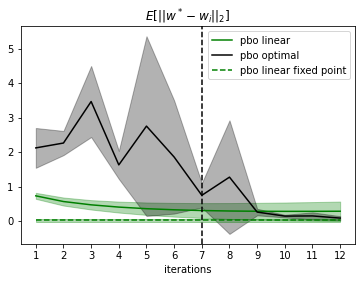

In [7]:
import matplotlib.pyplot as plt 

statistics, max_bellman_iterations_validation = extract_statistics("W")

iterations = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations, statistics["linear"]["mean"], label="pbo linear", color="green")
plt.fill_between(iterations, statistics["linear"]["lower_bound"], statistics["linear"]["upper_bound"], color="green", alpha=0.3)

# plt.plot(iterations, statistics["linear_on_weights"]["mean"], label="pbo linear on weights", color="grey")
# plt.fill_between(iterations, statistics["linear_on_weights"]["lower_bound"], statistics["linear_on_weights"]["upper_bound"], color="grey", alpha=0.3)

plt.plot(iterations, statistics["optimal"]["mean"], label="pbo optimal", color="black")
plt.fill_between(iterations, statistics["optimal"]["lower_bound"], statistics["optimal"]["upper_bound"], color="black", alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.hlines(statistics["linear_fixed_point"]["mean"], 1, len(iterations), color="green", linestyle="--", label="pbo linear fixed point")
plt.fill_between(iterations, statistics["linear_fixed_point"]["lower_bound"], statistics["linear_fixed_point"]["upper_bound"], color="green", alpha=0.3)
# plt.hlines(statistics["linear_on_weights_fixed_point"]["mean"], 1, len(iterations), color="grey", linestyle="--", label="pbo linear on weights fixed point")
# plt.fill_between(iterations, statistics["linear_on_weights_fixed_point"]["lower_bound"], statistics["linear_on_weights_fixed_point"]["upper_bound"], color="grey", alpha=0.3)

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$E[|| w^* - w_i ||_2]$")
plt.legend()
_ = plt.savefig(f"figures/sample_gap_{max_bellman_iterations}_W.jpg", bbox_inches='tight')